# <center>Visualization & Style Transfer<center/>

<center>Shan-Hung Wu & DataLab<center/>
<center>Fall 2023<center/>

This tutorial is going to show how to load and use a pretrained model from tensorflow library and discusses some techniques to visualize what the networks represent in the selected layers. In addition, we will introduce an interesting work called neural style transfer, using deep learning to compose one image in the style of another image.

## Import and configure modules

In [ ]:
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import os


''' 
runtime configuration parameters 
設定了兩個參數:
1. figure.figsize : 設定繪圖的預設圖片尺寸為 (12, 12) 英吋
2. axes.grid : 將繪圖中的網格（grid）關閉，即設為 False
'''
mpl.rcParams['figure.figsize'] = (12,12) 
mpl.rcParams['axes.grid'] = False

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# <center>Visualize Convolutional Neural Networks<center/>

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) # 將圖片的數據類型轉換為 tf.float32。這是為了將像素值縮放到範圍 [0, 1]，以便進行後續的處理。
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)  # 將 shape 的 tensor 轉換為 float32
    long_dim = max(shape) 
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32) # 滿足 max_dim 的 shape

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension 
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :] # 增加一個 batch 的維度
    
    return img

Create a simple function to display an image:

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [ ]:
content_path = './dataset/content_nthu.jpg'
content_image = load_img(content_path)
print('Image shape:', content_image.shape)
imshow(content_image, 'octopus')

## Load a pretrained network (VGG19)

We are going to visualize one of most remarkable neural networks, VGG19, which is introduced from this [paper](https://arxiv.org/abs/1409.1556), pretrained on ImageNet. VGG19 is known for its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. The "19" in its name stands for the number of layers in the network. ImageNet is a large dataset used in ImageNet Large Scale Visual Recognition Challenge(ILSVRC). The training dataset contains around 1.2 million images composed of 1000 different types of objects. The pretrained network learned how to create useful representations of the data to differentiate between different classes.

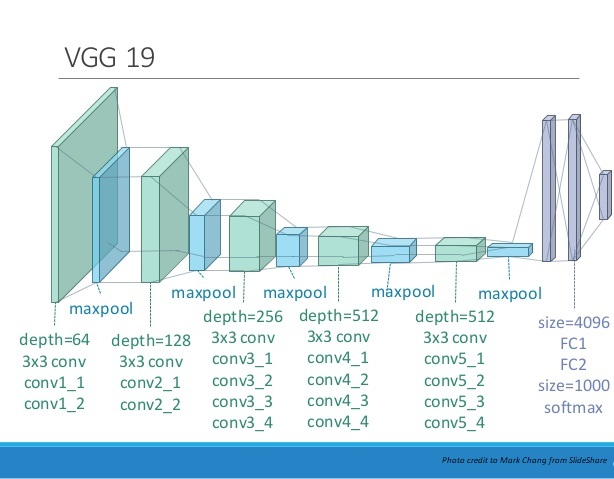

Load a VGG19 and test run it on our image to ensure it's used correctly. The output of VGG19 is the probabilities corresponding to 1000 categories.

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255) # 以 VGG19 模型的預處理方式來處理一個影像 content_image*255，是因為 VGG19 模型預處理的期望輸入值是在 0 到 255 之間的像素值。
x = tf.image.resize(x, (224, 224)) # VGG19 模型預期的輸入影像大小是 (224, 224, 3)

# load pretrained network(VGG19)
# include_top=True 表示包含模型的頂層（全連接層），而 weights='imagenet' 則表示使用在 ImageNet 數據集上預先訓練好的權重。
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')


prediction_probabilities = vgg(x) # 包含類別預測機率的張量
prediction_probabilities.shape

Obtain the top 5 predicted categories of the input image.

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

Let's try to first print out the detailed structure of VGG19. vgg.summary() shows the name, output shape and the number of parameters of each layer.

In [ ]:
vgg.summary()

## Visualize filters

Now we can visualize the weights of the convolution filters to help us understand what neural network have learned. In neural network terminology, the learned filters are simply weights, yet because of the specialized two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image is meaningful (or could be).

We can access the block of filters and the block of bias values through layer.get_weight(). In VGG19, all convolitional layers use 3x3 filters.

In [ ]:
# summarize filter shapes
for layer in vgg.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

Let's look at every single individual filter in the first convolutional layer. We will see all 64 in the block and plot each of the three channels. It is worth to meantion that in the first convolutional layer, it has total 192 feature maps(64 filters * 3 channels). We can normalize their values to the range 0-1 to make them easy to visualize.

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that the filters on the first row detect a gradient from light in the top left to dark in the bottom right.

In [ ]:
plt.figure(figsize=(16,16))

# retrieve weights from the second hidden layer
filters, biases = vgg.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 64, 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(14, 14, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
        
# show the figure
pyplot.show()

## Visualize feature maps

The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map. The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features.

We can see that the result of applying the filters in the first convolutional layer is a lot of versions of the input image with different features highlighted. For example, some highlight lines, other focus on the background or the foreground.

In [ ]:
plt.figure(figsize=(16,16))

# redefine model to output right after the first hidden layer
model = tf.keras.Model(inputs=[vgg.input], outputs=vgg.layers[1].output)
model.summary()

# preprocess input
# 在這個上下文中，`content_image*255` 是將 `content_image` 中的每個像素值乘以 255。這通常是因為圖像數據在讀取時被歸一化到了 0 到 1 的範圍
content_image = tf.keras.applications.vgg19.preprocess_input(content_image*255) 

content_image = tf.image.resize(content_image, (224, 224))

# get feature map for first hidden layer
feature_maps = model.predict(content_image)

# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
        
# show the figure
pyplot.show()

在這個上下文中，`content_image*255` 是將 `content_image` 中的每個像素值乘以 255。這通常是因為圖像數據在讀取時被歸一化到了 0 到 1 的範圍，而原始的像素值範圍是 0 到 255。所以這個操作是將像素值從 0-1 範圍轉換回 0-255 範圍，這是 VGG19 模型預期的輸入範圍。

讓我們視覺化模型的每個區塊輸出的特徵圖。您可能會注意到，更深層的特徵圖的數量（例如深度或通道數）遠遠超過 64，例如 256 或 512。儘管如此，為了保持一致性，我們可以將可視化的特徵圖數量限制在 64。

我們可以看到，靠近模型輸入的特徵圖捕捉到圖像中的很多細節，隨著我們深入模型，特徵圖顯示的細節越來越少。

這種模式是可以預期的，因為模型將圖像中的特徵抽象成更一般的概念，可用於進行分類。儘管從最終圖像中無法清楚看出模型看到了清華大學校園，但我們通常會失去解釋這些更深層特徵圖的能力。

In [ ]:
# get feature maps for last convolutional layer in each block
ixs = [2, 5, 10, 15, 20]
outputs = [vgg.layers[i].output for i in ixs]
model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)
feature_maps = model.predict(content_image)

# plot the output from each block
square = 8
for i, fmap in enumerate(feature_maps):
    # plot all 64 maps in an 8x8 squares
    ix = 1
    print(outputs[i])
    plt.figure(figsize=(16,16))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
            
    # show the figure
    pyplot.show()

## Visualize gradients


視覺化卷積層輸出是一種相當有用的技術，用於可視化淺層卷積層，但是當我們進入深層時，僅僅通過看卷積輸出來理解它們變得很難。

如果我們想要理解深層到底在做什麼，我們可以嘗試使用反向傳播，以顯示特定神經元對輸入圖像的梯度。我們將進行前向傳遞，直到達到我們感興趣的層，然後進行反向傳播，以幫助我們理解哪些像素對該層的激活做出了最大的貢獻。

We first create an operation which will find the maximum neurons among all activations in the required layer, and then calculate the gradient of that objective with respect to the input image.

In [ ]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
class GradientModel(tf.keras.models.Model):
    def __init__(self, layers):
        super(GradientModel, self).__init__()
        self.vgg =  vgg_layers(layers)
        self.num_style_layers = len(layers)
        self.vgg.trainable = False
        
    # return the feature map of required layer
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        return outputs

Compute the gradient of maximum neurons among all activations in the required layer with respect to the input image.

In [ ]:
@tf.function()
def visualize_gradient(image):
    with tf.GradientTape() as tape:
        feature = extractor(image)
        print(f"feature shape: {feature.shape}")
        print(f"tf.reduce_max(feature, axis=3)shape: {tf.reduce_max(feature, axis=3).shape}")
        # grad = d_feature/d_image
        
        grad = tape.gradient(tf.reduce_max(feature, axis=3), image)
        
    return grad

In [ ]:
content_image = load_img(content_path)

# activation layer
layers = ['block4_conv2']
image = tf.Variable(content_image)
extractor = GradientModel(layers)

grad = visualize_gradient(image)

# look at the range of gradients
print("shape: ", grad.numpy().shape)
print("min: ", grad.numpy().min())
print("max: ", grad.numpy().max())
print("mean: ", grad.numpy().mean())

In [ ]:
# normalize filter values to 0-1 so we can visualize them
g_min, g_max = grad.numpy().min(), grad.numpy().max()
filters = (grad - g_min) / (g_max - g_min)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(image.read_value()[0])

plt.subplot(1, 2, 2)
print(filters.shape)
imshow(filters[0])

We can also visualize the gradient of any single feature map.

In [ ]:
@tf.function()
def visualize_gradient_single_layer(image, layer_i):
    with tf.GradientTape() as tape:
        feature = extractor(image)
        print(f"feature shape: {feature.shape}")
        grad = tape.gradient(tf.reduce_mean(feature[:, :, :, layer_i]), image)
    return grad

In [ ]:
plt.figure(figsize=(14,10))

grad = visualize_gradient_single_layer(image, 77)

# normalize filter values to 0-1 so we can visualize them
g_min, g_max = grad.numpy().min(), grad.numpy().max()
filters = (grad - g_min) / (g_max - g_min)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(image.read_value()[0])

plt.subplot(1, 2, 2)
imshow(filters[0])


正如上文所述，結果仍然難以解釋且令人不太滿意。每個像素通過多個隱藏神經元影響著神經元。

理想情況下，神經元應該像某種圖像特徵的檢測器。我們只關心神經元檢測到了哪些圖像特徵，而不關心它未檢測到什麼樣的內容。因此，在傳播梯度時，我們將所有負梯度設為0。

## Guided-Backpropagation

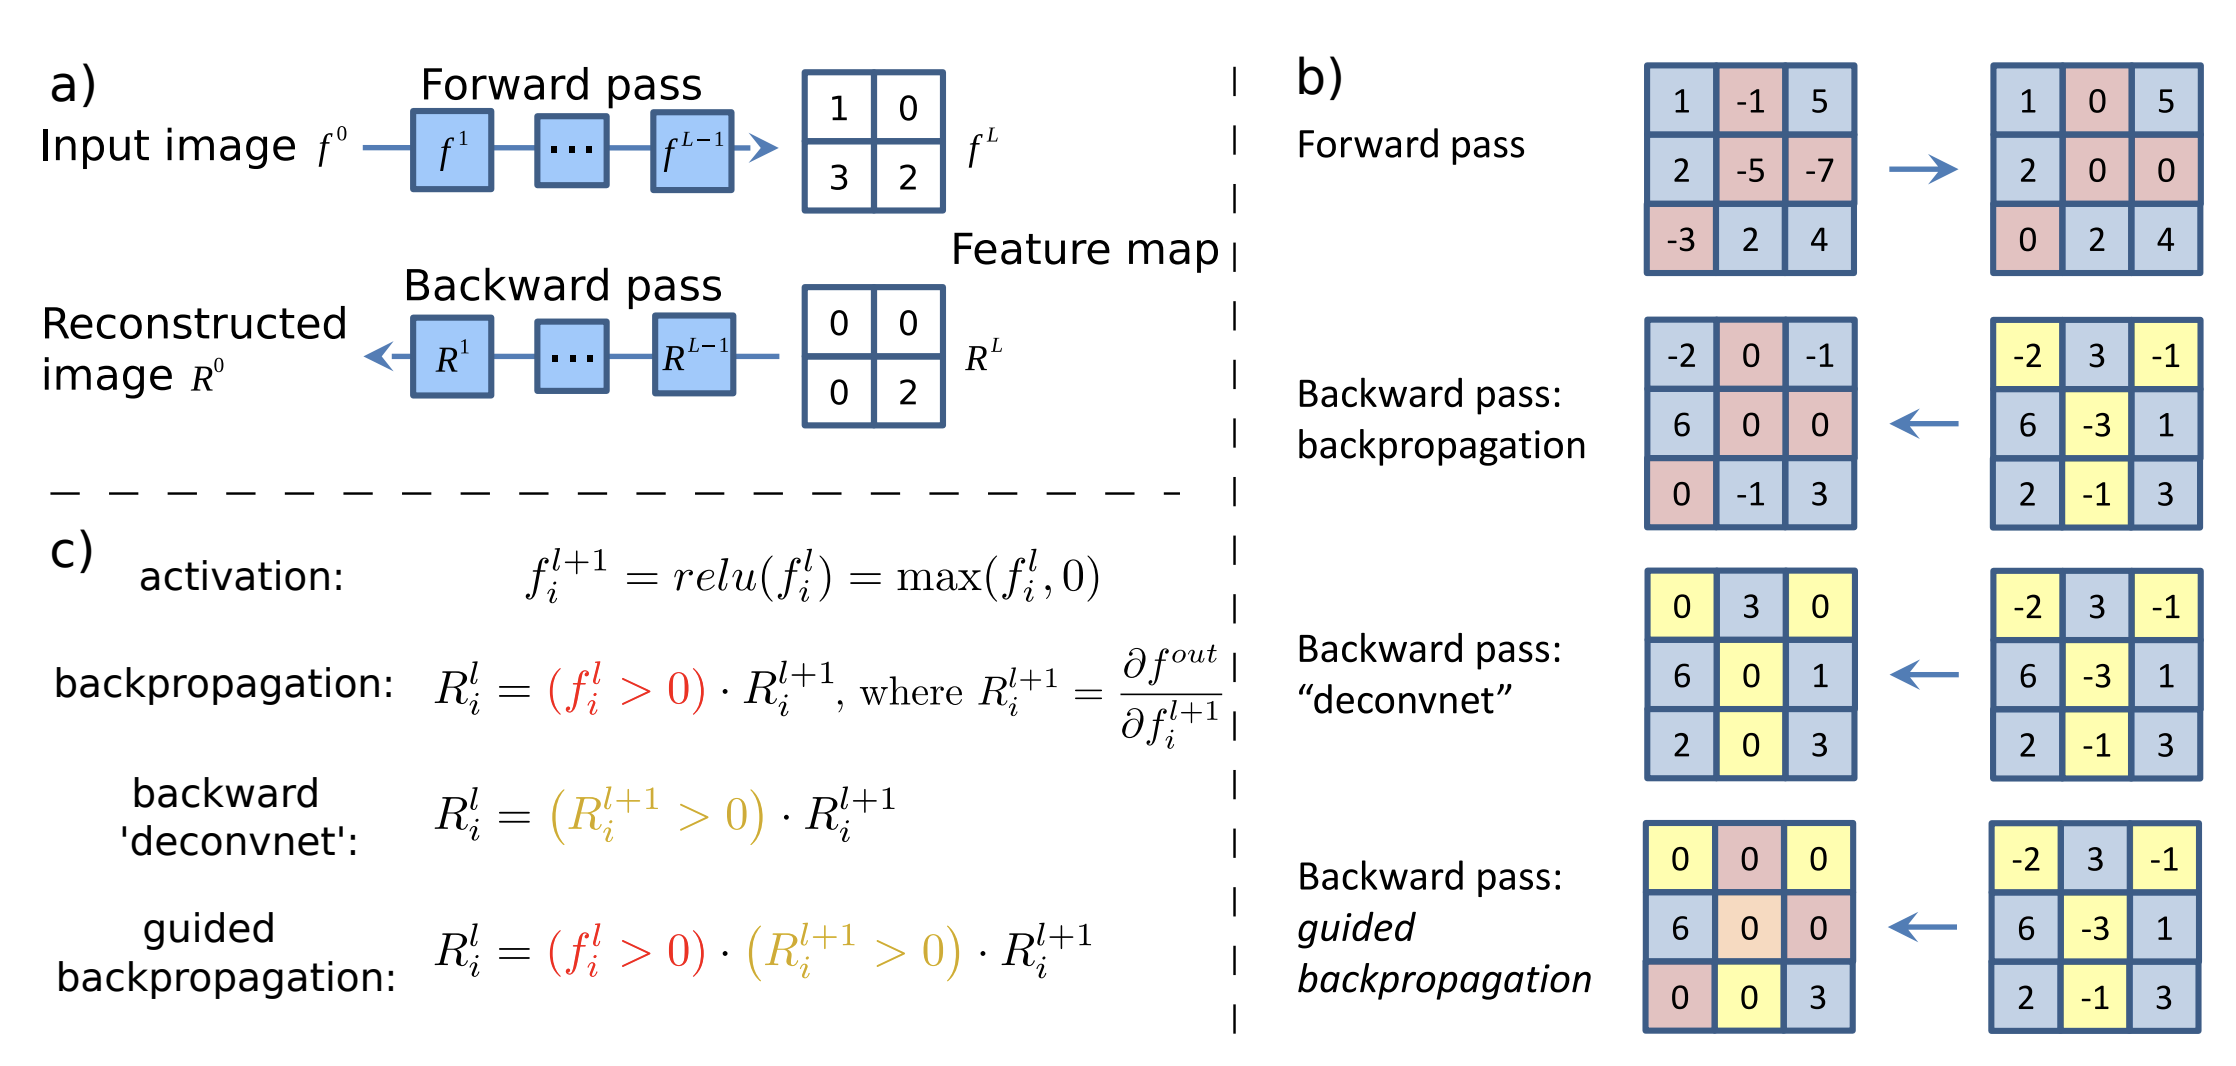

我們稱這種方法為引導反向傳播（guided backpropagation），因為它向通常的反向傳播添加了一個來自較高層的額外引導信號。這防止了負梯度的反向流動，這對應於降低我們希望可視化的較高層單元的激活的神經元。有關更多詳細信息，請參閱J. T. Springenberg和A. Dosovitskiy等人的 [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/pdf/1412.6806.pdf) 的精彩工作。

In [ ]:
from guided_backprop import GuidedBackprop

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

# backprop_vgg = GuidedBackprop(model=vgg, layerName='predictions') # original
backprop_vgg = GuidedBackprop(model=vgg, layerName='block5_conv4') # use this layer instead, b/c we need to extract from vgg19.
grad = backprop_vgg.guided_backprop(x)[0].numpy()

In [ ]:
# plot the original image and the three saliency map variants
plt.figure(figsize=(16, 16), facecolor='w')
plt.subplot(2, 2, 1)
plt.title('Input')
plt.imshow(tf.image.resize(content_image, (224, 224))[0])
plt.subplot(2, 2, 2)
plt.title('Abs. saliency')
plt.imshow(np.abs(grad).max(axis=-1), cmap='gray')
plt.subplot(2, 2, 3)
plt.title('Pos. saliency')
plt.imshow((np.maximum(0, grad) / grad.max()))
plt.subplot(2, 2, 4)
plt.title('Neg. saliency')
plt.imshow((np.maximum(0, -grad) / -grad.min()))
plt.show()

# A Neural Algorithm of Artistic Style


視覺化神經網絡能夠更好地理解這個神秘的龐大網絡中正在發生的事情。除了這個應用外，Leon Gatys及其合著者們還有一項非常有趣的工作，名為[《A Neural Algorithm of Artistic Style》](https://arxiv.org/abs/1508.06576)。該工作使用神經表示來區分和重新組合任意圖像的內容和風格，提供了一種創造藝術圖像的神經算法。

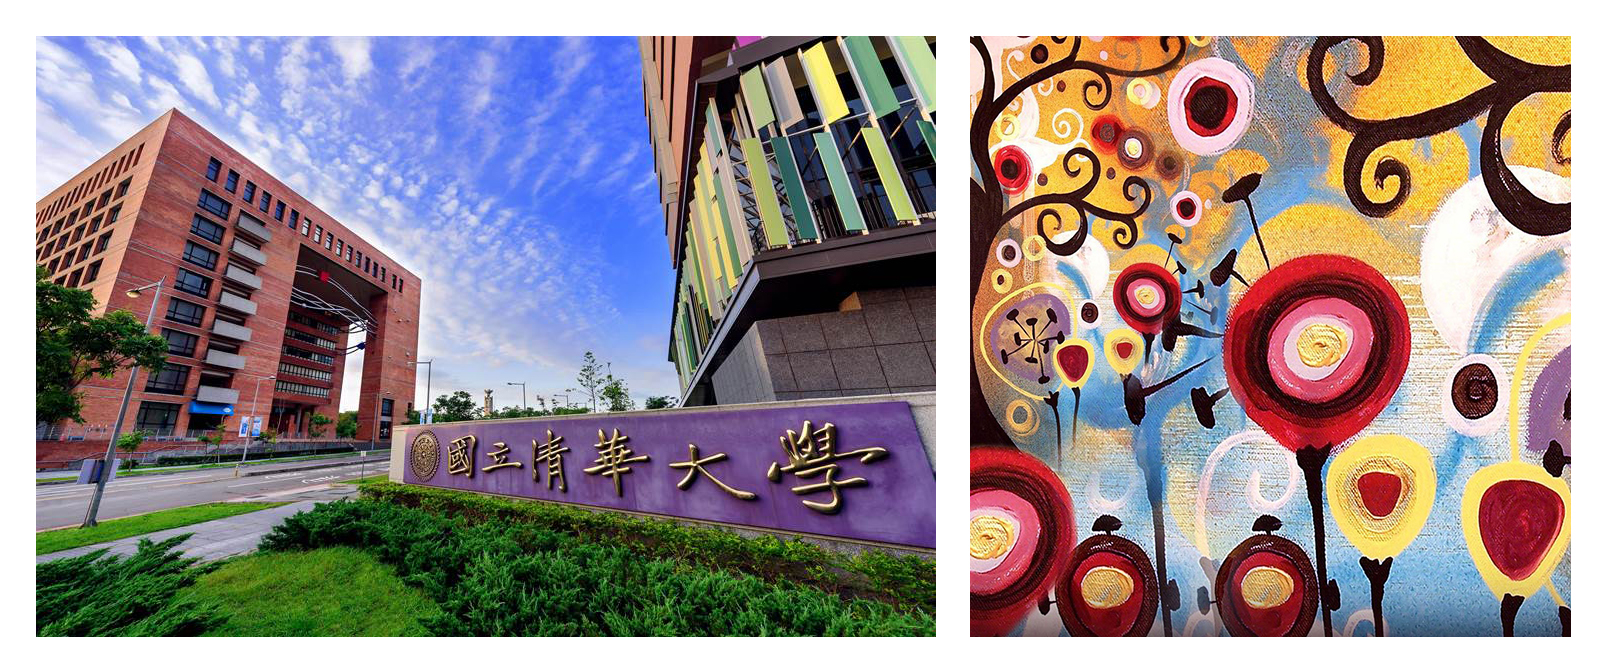

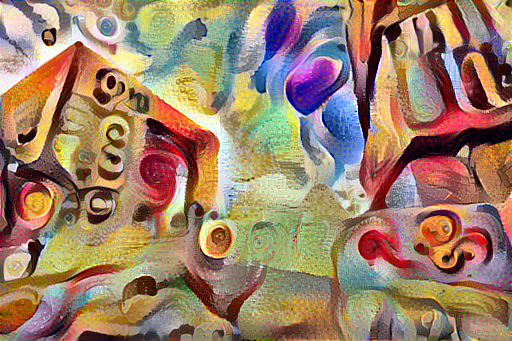

## Define content and style representations

使用模型的中間層來獲得圖像的內容和風格表示。從網絡的輸入層開始，前幾個層的激活表示低級特徵，如邊緣和紋理。當你通過網絡進行步進時，最後幾層表示高級特徵，如輪子或眼睛等物體部分。在這種情況下，您使用的是VGG19網絡架構，這是一個預訓練的圖像分類網絡。這些中間層對於定義從圖像中提取內容和風格的表示是必要的。對於輸入圖像，請嘗試在這些中間層匹配相應的風格和內容目標表示。

In [ ]:
content_path = './dataset/content_nthu.jpg'
style_path = './dataset/style_starry_night.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

Now load a VGG19 without the classification head, and list the layer names.

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

- Content features of the content image is calculated by feeding the content image into the neural network, and extract the activations of those content_layers.

- For style features, we extract the correlation of the features of the style-image layer-wise (gram matrix). By adding up the feature correlations of multiple layers, which corresponding to style_layers, we obtain a multi-scale representation of the input image, which captures its texture information instead of the object arrangement in the input image.

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

在高層次上，為了使一個網絡能夠執行圖像分類（這是該網絡被訓練來執行的任務），它必須理解圖像。這需要將原始圖像作為輸入像素，並建構一個內部表示，將原始圖像像素轉換為對圖像內部特徵的複雜理解。

這也是卷積神經網絡能夠很好地泛化的原因之一：它們能夠捕捉類別內（例如貓 vs. 狗）不受背景噪音和其他干擾影響的不變性和定義特徵。因此，在模型接收到原始圖像並輸出預測標籤之間，模型充當了一個複雜的特徵提取器。通過訪問模型的中間層，你能夠描述輸入圖像的內容和風格。

## Build the model


tf.keras.applications 中的網絡被設計成可以輕松使用 Keras 函數式 API 提取中間層的值。

要使用函數式 API 定義一個模型，請指定輸入和輸出：

model = Model(inputs, outputs)

In [ ]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

## Calculate style

圖像的風格可以通過不同特徵圖的均值和相互關係來描述。通過在每個位置將特徵向量與自身進行外積，然後在所有位置上對該外積進行平均，可以計算包含此信息的 Gram 矩陣。對於特定的層，可以計算這個 Gram 矩陣：

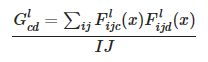

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

## Extract style and content

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

## Define loss

我們的目標是創建一個輸出圖像，該圖像是通過找到一個同時匹配照片的內容特徵和相應藝術作品的風格特徵的圖像來合成的。我們如何做到這一點呢？我們可以將損失函數定義為以下兩部分的組合：

1. 輸出圖像與內容圖像之間的內容特徵的不相似性
2. 輸出圖像與風格圖像之間的風格特徵的不相似性

下圖很好地視覺化了這個過程：

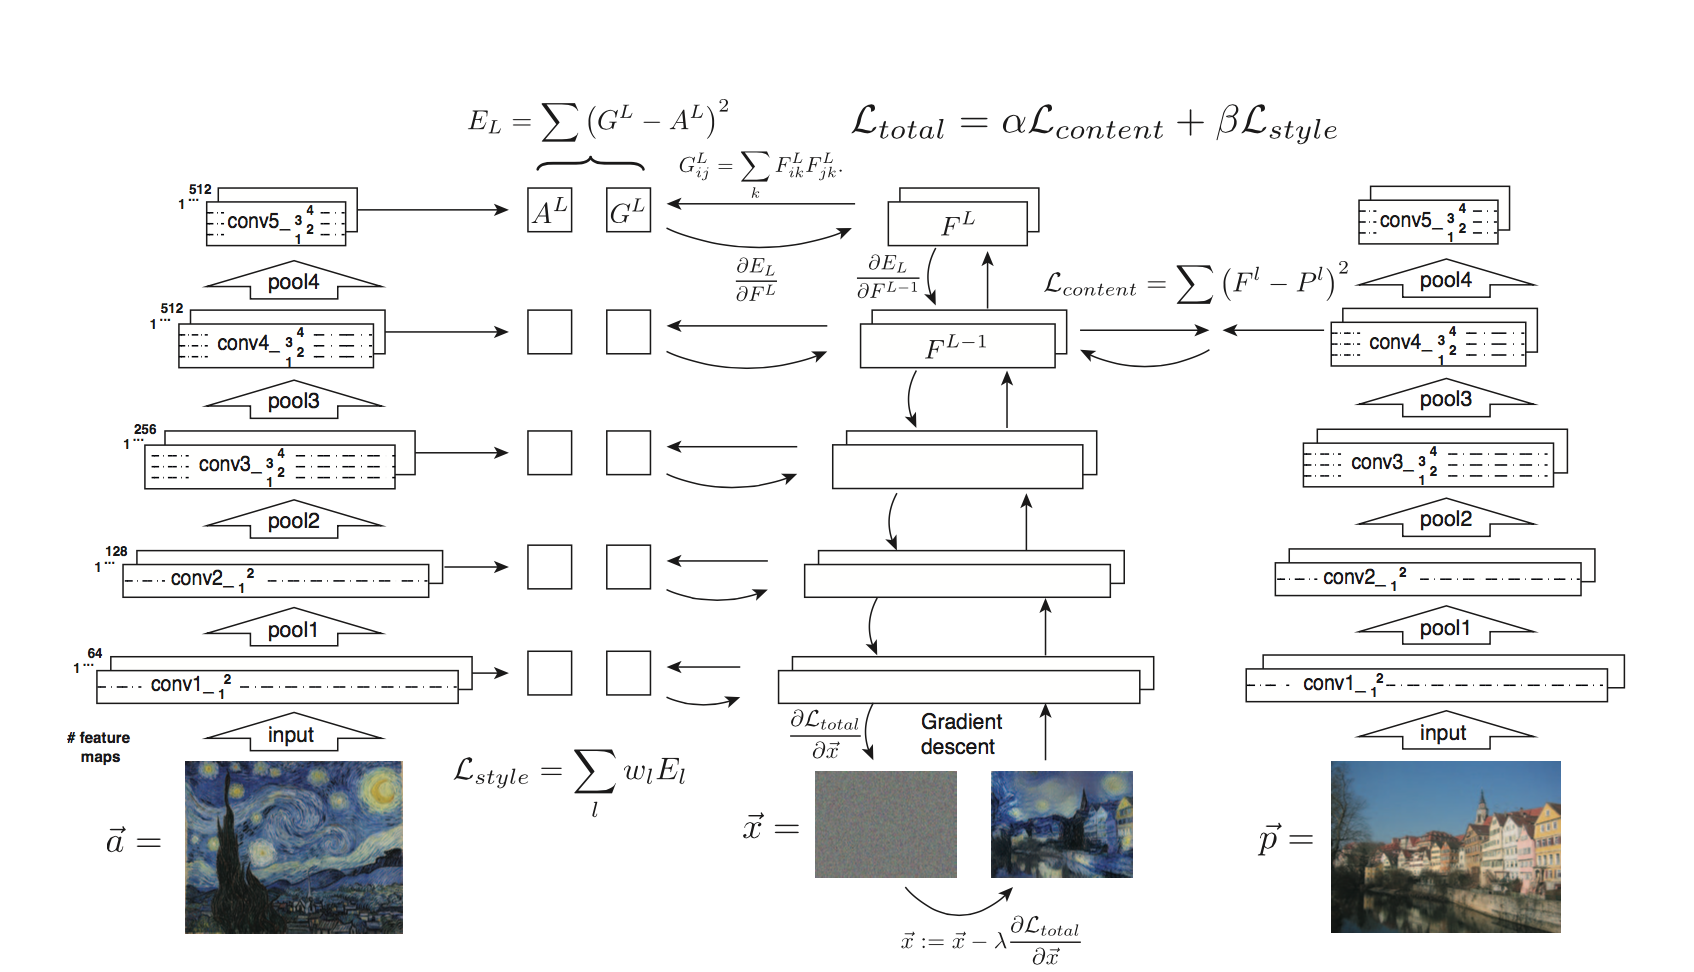

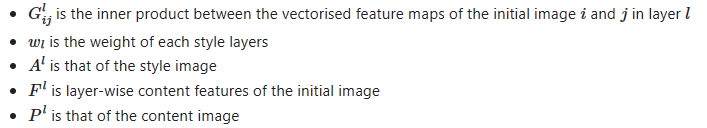

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Run gradient descent

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    # tape.gradient: d_loss/d_image
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 1   # Change it as you want
content_weight = 10000  # Change it as you want

train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

Let's train with more iteration to see the results!

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()
    

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

這個基本實現的一個缺點是它會產生很多高頻雜訊。可以通過在圖像的高頻成分上使用顯式正則化項來減少這些雜訊。在風格轉換中，這通常被稱為總變異損失。

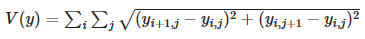

在實際操作中，為了加快計算速度，我們實施以下版本：

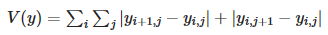

這顯示了高頻成分是如何增加的。此外，這個高頻成分基本上是一個邊緣檢測器。例如，你可以從 Sobel 邊緣檢測器獲得類似的輸出。

In [ ]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
def total_variation_loss(image):
    # TODO
    first_diff = image[:, :-1, :, :] - image[:, 1:, :, :]
    second_diff = image[:, :, :-1, :] - image[:, :, 1:, :]  
    
    total_var = tf.reduce_sum(tf.abs(first_diff), axis=(1,2,3)) + tf.reduce_sum(tf.abs(second_diff), axis=(1,2,3))
    
    return total_var



## Re-run the optimization

In [ ]:
total_variation_weight = 10 # Change it as you want

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [ ]:
image = tf.Variable(content_image)

In [ ]:
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = './dataset/style_transfer_nthu_starry_night.png'
mpl.image.imsave(file_name, image[0].numpy())

## AdaIN

我們之前提到的方法需要一個緩慢的迭代優化過程，這限制了其實際應用。來自康奈爾大學的Xun Huang和Serge Belongie提出了另一種框架，該框架能夠實時進行任意風格轉換，被稱為"實時自適應實例歸一化的任意風格轉換"。

AdaIN可以實時轉換任意新風格，結合了基於優化的框架的靈活性和與最快的前向方法相似的速度。這種方法的核心是一種新的自適應實例歸一化（AdaIN）層，該層將內容特徵的均值和方差與風格特徵的均值和方差對齊。實例歸一化通過歸一化特徵統計數據來進行風格歸一化，這些特徵統計數據在早期的工作中被發現可以攜帶圖像的風格信息。然後學習一個解碼網絡，通過將AdaIN輸出反轉回圖像空間來生成最終的風格化圖像。

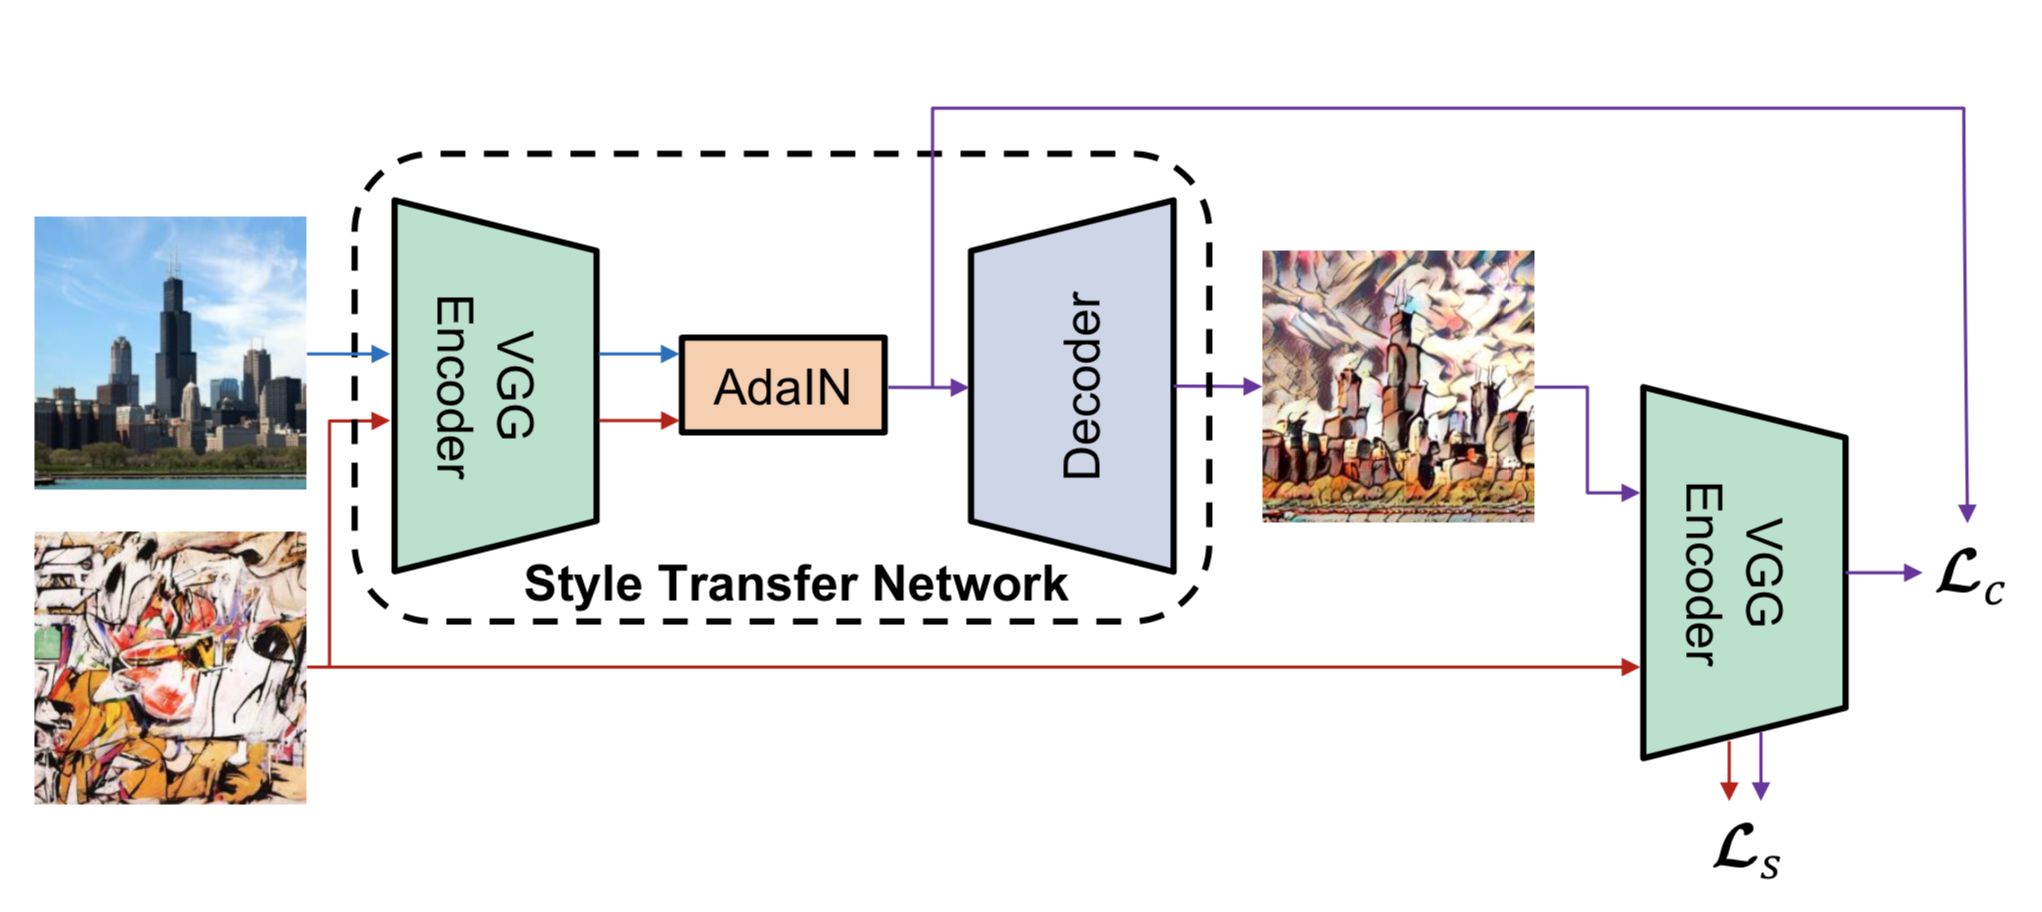

In [ ]:
%matplotlib inline

CONTENT_DIRS = ['./dataset/mscoco']
STYLE_DIRS = ['./dataset/wikiart']

# VGG19 was trained by Caffe which converted images from RGB to BGR,
# then zero-centered each color channel with respect to the ImageNet 
# dataset, without scaling.  
IMG_MEANS = np.array([103.939, 116.779, 123.68]) # BGR

IMG_SHAPE = (224, 224, 3) # training image shape, (h, w, c)
SHUFFLE_BUFFER = 1000
BATCH_SIZE = 32
EPOCHS = 30
STEPS_PER_EPOCH = 12000 // BATCH_SIZE

在這裡，我們使用 MSCOCO 2014 測試數據集作為我們的內容數據集，同時使用 WikiArt 測試數據集作為風格數據集，分別包含 40,736 和 23,585 張圖片。為了防止誤解，我們必須澄清使用測試數據集而不是訓練數據集的原因。整個 MSCOCO 2014 和 WikiArt 的大小超過 45G，對於這個教程來說可能太大了。此外，我們的目的是訓練一個風格轉換模型，而不是圖像分類或物體檢測，因此使用測試數據集是沒有問題的。

In [ ]:
def sample_files(dir, num, pattern='**/*.jpg'):
    '''Samples files in a directory using the reservoir sampling.'''

    paths = Path(dir).glob(pattern) # list of Path objects
    sampled = []
    for i, path in enumerate(paths):
        if i < num:
            sampled.append(path) 
        else:
            s = random.randint(0, i)
            if s < num:
                sampled[s] = path
    return sampled

def plot_images(dir, row, col, pattern):
    paths = sample_files(dir, row*col, pattern)

    plt.figure(figsize=(2*col, 2*row))
    for i in range(row*col):
        im = Image.open(paths[i])
        w, h = im.size

        plt.subplot(row, col, i+1)
        plt.imshow(im)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'{w}x{h}')
    plt.show()

print('Sampled content images:')
plot_images(CONTENT_DIRS[0], 4, 8, pattern='*.jpg')

print('Sampled style images:')
plot_images(STYLE_DIRS[0], 4, 8, pattern='*.jpg')

## Dataset API

Before creating dataset API, first we have to remove some unwanted data, such as small images or grayscale images.

In [ ]:
def clean(dir_path, min_shape=None):
    paths = Path(dir_path).glob('**/*.jpg')
    deleted  = 0
    for path in paths:
        try:
            # Make sure we can decode the image
            im = tf.io.read_file(str(path.resolve())) # path.resolve() 是 pathlib.Path 类的一个方法，用于获取路径的绝对路径（absolute path）
            im = tf.image.decode_jpeg(im) 

            # Remove grayscale images 
            shape = im.shape
            if shape[2] < 3:
                path.unlink()
                deleted += 1

            # Remove small images
            if min_shape is not None:
                if shape[0] < min_shape[0] or shape[1] < min_shape[1]:
                    path.unlink()
                    deleted += 1
        except Exception as e:
            path.unlink()
            deleted += 1
    return deleted

for dir in CONTENT_DIRS:
    deleted = clean(dir)
print(f'#Deleted content images: {deleted}')

for dir in STYLE_DIRS:
    deleted = clean(dir)
print(f'#Deleted style images: {deleted}')

VGG19是由Caffe訓練的，該框架將圖像從RGB轉換為BGR，然後對每個顏色通道進行零居中處理，以適應ImageNet數據集，而不進行縮放。因此，在數據預處理過程中，我們需要執行相同的操作。

In [ ]:
def preprocess_image(path, init_shape=(448, 448)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, init_shape)
    image = tf.image.random_crop(image, size=IMG_SHAPE)
    image = tf.cast(image, tf.float32)
    
    # Convert image from RGB to BGR, then zero-center each color channel with
    # respect to the ImageNet dataset, without scaling.
    image = image[..., ::-1] # RGB to BGR
    image -= (103.939, 116.779, 123.68) # BGR means
    return image

def np_image(image):
    image += (103.939, 116.779, 123.68) # BGR means
    image = image[..., ::-1] # BGR to RGB
    image = tf.clip_by_value(image, 0, 255)
    image = tf.cast(image, dtype='uint8')
    return image.numpy()

def build_dataset(num_gpus=1):
    c_paths = []
    for c_dir in CONTENT_DIRS:
        c_paths += Path(c_dir).glob('*.jpg')
    c_paths = [str(path.resolve()) for path in c_paths]
    s_paths = []
    for s_dir in STYLE_DIRS:
        s_paths += Path(s_dir).glob('*.jpg')
    s_paths = [str(path.resolve()) for path in s_paths]
    print(f'Building dataset from {len(c_paths):,} content images and {len(s_paths):,} style images... ', end='')

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    c_ds = tf.data.Dataset.from_tensor_slices(c_paths)
    c_ds = c_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    c_ds = c_ds.repeat()
    c_ds = c_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    s_ds = tf.data.Dataset.from_tensor_slices(s_paths)
    s_ds = s_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    s_ds = s_ds.repeat()
    s_ds = s_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    ds = tf.data.Dataset.zip((c_ds, s_ds))
    ds = ds.batch(BATCH_SIZE * num_gpus)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    print('done')
    return ds

In [ ]:
ds = build_dataset()
c_batch, s_batch = next(iter(ds.take(1)))

print('Content batch shape:', c_batch.shape)
print('Style batch shape:', s_batch.shape)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(np_image(c_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Content')

plt.subplot(1, 2, 2)
plt.imshow(np_image(s_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Style')

plt.show()

## Adaptive Instance Normalization

AdaIN（自適應實例標準化）接收一個 內容輸入 x 和 風格輸入 y，並簡單地使 x 的 channelwise mean 和 variance 與 y 的相匹配。值得注意的是，與 BN（批次標準化）、IN（實例標準化）或 CIN（條件實例標準化）不同，AdaIN 沒有可學習的仿射參數。相反，它從風格輸入中自適應計算仿射參數。

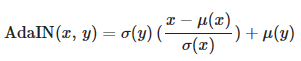

In [ ]:
class AdaIN(tf.keras.layers.Layer):
    # TODO
    def __init__(self, name):
        super(AdaIN, self).__init__(name=name)
        self.epsilon = 1e-9
        
    def call(self, input):
        x, y = input
        x_mean, x_var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        y_mean, y_var = tf.nn.moments(y, axes=[1, 2], keepdims=True)
        x_std, y_std = tf.sqrt(x_var), tf.sqrt(y_var)
        return y_std * (x - x_mean) / (x_std + self.epsilon) + y_mean


## Model

We use the first few layers of a fixed VGG-19 network to encode the content and style images. An AdaIN layer is used to perform style transfer in the feature space. A decoder is learned to invert the AdaIN output to the image spaces. Moreover, we use the same VGG encoder to compute a content loss $L_c$ and style loss $L_s$. Here we define t as the output of AdaIN layer.

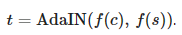

Next, we can define the loss function which is composed of content loss and style loss, where λ is weighting factor.

The content loss is the Euclidean distance between the target features and the features of the output image. We use the AdaIN output t as the content target, instead of the commonly used feature responses of the content image. The author found this leads to slightly faster convergence and also aligns with our goal of inverting the AdaIN output t.

Since AdaIN layer only transfers the mean and standard deviation of the style features, our style loss only matches these statistics. Although we find the commonly used Gram matrix loss can produce similar results, we match the IN statistics because it is conceptually cleaner. This style loss has also been explored by [Li et al](https://arxiv.org/pdf/1701.01036.pdf).

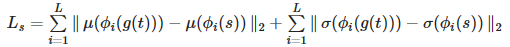

- c represents content while 
- s represents style
- t is the output of AdaIN layer
- f is encoder
- g is decoder
- $ϕ_i$ denotes a layer in VGG-19 used to compute the style loss

In [ ]:
class ArbitraryStyleTransferNet(tf.keras.Model):
    CONTENT_LAYER = 'block4_conv1'
    STYLE_LAYERS = ('block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1')

    @staticmethod
    def declare_decoder():
        a_input = tf.keras.Input(shape=(28, 28, 512), name='input_adain')

        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(a_input)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        output = tf.keras.layers.Conv2DTranspose(3, 3, padding='same')(h)

        return tf.keras.Model(inputs=a_input, outputs=output, name='decoder')
  
    def __init__(self,
                 img_shape=(224, 224, 3),
                 content_loss_weight=1,
                 style_loss_weight=10,
                 name='arbitrary_style_transfer_net',
                 **kwargs):
        super(ArbitraryStyleTransferNet, self).__init__(name=name, **kwargs)

        self.img_shape = img_shape
        self.content_loss_weight = content_loss_weight
        self.style_loss_weight = style_loss_weight
        
        vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=img_shape)
        vgg19.trainable = False

        c_output = [vgg19.get_layer(ArbitraryStyleTransferNet.CONTENT_LAYER).output]
        s_outputs = [vgg19.get_layer(name).output for name in ArbitraryStyleTransferNet.STYLE_LAYERS]
        self.vgg19 = tf.keras.Model(inputs=vgg19.input, outputs=c_output+s_outputs, name='vgg19')
        self.vgg19.trainable = False

        self.adain = AdaIN(name='adain')
        self.decoder = ArbitraryStyleTransferNet.declare_decoder()
  
    def call(self, inputs):
        c_batch, s_batch = inputs

        c_enc = self.vgg19(c_batch)
        c_enc_c = c_enc[0]

        s_enc = self.vgg19(s_batch)
        s_enc_c = s_enc[0]
        s_enc_s = s_enc[1:] 
        
        # normalized_c is the output of AdaIN layer
        normalized_c = self.adain((c_enc_c, s_enc_c))
        output = self.decoder(normalized_c)

        # Calculate loss
        out_enc = self.vgg19(output)
        out_enc_c = out_enc[0]
        out_enc_s = out_enc[1:]

        loss_c = tf.reduce_mean(tf.math.squared_difference(out_enc_c, normalized_c))
        self.add_loss(self.content_loss_weight * loss_c)
        
        loss_s = 0
        for o, s in zip(out_enc_s, s_enc_s):    
            o_mean, o_var = tf.nn.moments(o, axes=(1,2), keepdims=True)
            o_std = tf.sqrt(o_var + self.adain.epsilon)

            s_mean, s_var = tf.nn.moments(s, axes=(1,2), keepdims=True)
            s_std = tf.sqrt(s_var + self.adain.epsilon)

            loss_mean = tf.reduce_mean(tf.math.squared_difference(o_mean, s_mean))
            loss_std = tf.reduce_mean(tf.math.squared_difference(o_std, s_std))

            loss_s += loss_mean + loss_std
        self.add_loss(self.style_loss_weight * loss_s)

        return output, c_enc_c, normalized_c, out_enc_c

In [ ]:
# Plot results
def plot_outputs(outputs, captions=None, col=5):
    row = len(outputs)
    plt.figure(figsize=(3*col, 3*row))
    for i in range(col):
        for j in range(row):
            plt.subplot(row, col, j*col+i+1)
            plt.imshow(np_image(outputs[j][i,...,:3]))
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            if captions is not None:
                plt.xlabel(captions[j])
    plt.show()

In [ ]:
ds = build_dataset()
model = ArbitraryStyleTransferNet(img_shape=IMG_SHAPE)

c_batch, s_batch = next(iter(ds.take(1)))
print(f'Input shape: ({c_batch.shape}, {s_batch.shape})')
output, *_ = model((c_batch, s_batch))
print(f'Output shape: {output.shape}')
print(f'Init. content loss: {model.losses[0]:,.2f}, style loss: {model.losses[1]:,.2f}')
model.summary()

## Training

In [ ]:
# Train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
c_loss_metric, s_loss_metric = tf.keras.metrics.Mean(), tf.keras.metrics.Mean()

CKP_DIR = 'checkpoints'
init_epoch = 1

ckp = tf.train.latest_checkpoint(CKP_DIR)
if ckp:
    model.load_weights(ckp)
    init_epoch = int(ckp.split('_')[-1]) + 1
    print(f'Resume training from epoch {init_epoch-1}')

In [ ]:
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        model(inputs)
        c_loss, s_loss = model.losses
        loss = c_loss + s_loss
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    c_loss_metric(c_loss)
    s_loss_metric(s_loss)

In [ ]:
def train(dataset, init_epoch):
    for epoch in range(init_epoch, EPOCHS+1):
        print(f'Epoch {epoch:>2}/{EPOCHS}')
        for step, inputs in enumerate(ds.take(STEPS_PER_EPOCH)):
            train_step(inputs)
            print(f'{step+1:>5}/{STEPS_PER_EPOCH} - loss: {c_loss_metric.result()+s_loss_metric.result():,.2f} - content loss: {c_loss_metric.result():,.2f} - style loss: {s_loss_metric.result():,.2f}', end='\r') 

        print()
        model.save_weights(os.path.join(CKP_DIR, f'ckpt_{epoch}'))
        c_loss_metric.reset_states()
        s_loss_metric.reset_states()

        output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
        plot_outputs((s_batch, c_batch, output, c_enc_c, normalized_c, out_enc_c), 
                     ('Style', 'Content', 'Trans', 'Content Enc', 'Normalized', 'Trans Enc'))

In [ ]:
train(ds, init_epoch)

## Testing

In [ ]:
CKP_DIR = 'checkpoints/ckpt_20'

model = ArbitraryStyleTransferNet(img_shape=IMG_SHAPE)
model.load_weights(CKP_DIR)

ds = build_dataset()

for idx, (c_batch, s_batch) in enumerate(ds):
    if idx > 1:
        break
    output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
    print('Recovered loss:', tf.reduce_sum(model.losses).numpy())

    plot_outputs((s_batch, c_batch, output), ('Style', 'Content', 'Trans'))

## NTHU Example

One of the most important advantages of AdaIN is speed. Earlier we have implemented iterative style transfer, which takes roughly 30 seconds per image on Nvidia GeForce RTX 2080Ti, meanwhile AdaIN is up to three orders of magnitude faster than the former. Here we demostrate the power of AdaIN with single content and 25 distinct styles.

In [ ]:
def preprocess_example(path, init_shape=(IMG_SHAPE[0], IMG_SHAPE[1])):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, init_shape)
    image = tf.cast(image, tf.float32)
    
    # Convert image from RGB to BGR, then zero-center each color channel with
    # respect to the ImageNet dataset, without scaling.
    image = image[..., ::-1] # RGB to BGR
    image -= (103.939, 116.779, 123.68) # BGR means
    return image

def nthu_example(num_gpus=1):
    c_paths = ['./dataset/content_nthu.jpg']
    
    s_paths = []
    for s_dir in STYLE_DIRS:
        s_paths += Path(s_dir).glob('*.jpg')
    s_paths = [str(path.resolve()) for path in s_paths]
    print(f'Building dataset from {len(c_paths):,} content images and {len(s_paths):,} style images... ', end='')
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    c_ds = tf.data.Dataset.from_tensor_slices(c_paths)
    c_ds = c_ds.map(preprocess_example, num_parallel_calls=AUTOTUNE)
    c_ds = c_ds.repeat()
    c_ds = c_ds.shuffle(buffer_size=SHUFFLE_BUFFER)
    
    s_ds = tf.data.Dataset.from_tensor_slices(s_paths)
    s_ds = s_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    s_ds = s_ds.repeat()
    s_ds = s_ds.shuffle(buffer_size=SHUFFLE_BUFFER)
    
    ds = tf.data.Dataset.zip((c_ds, s_ds))
    ds = ds.batch(BATCH_SIZE * num_gpus)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    print('done')
    return ds

In [ ]:
ds = nthu_example()
outputs = []

for idx, (c_batch, s_batch) in enumerate(ds):
    if idx > 4:
        break
    output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
    outputs.append(output)
    
plot_outputs((outputs))

# Save and Load Models

Model progress can be saved during and after training. This means a model can resume where it left off and avoid long training times. Saving also means you can share your model and others can recreate your work. When publishing research models and techniques, most machine learning practitioners share:

- code to create the model, and
- the trained weights, or parameters, for the model

Sharing this data helps others understand how the model works and try it themselves with new data.

The phrase "Saving a Tensorflow model" typically means one of two things:

3. Checkpoints, OR
2. SavedModel.

Checkpoints capture the exact value of all parameters (tf.Variable objects) used by a model. Checkpoints do not contain any description of the computation defined by the model and thus are typically only useful when source code that will use the saved parameter values is available.

The SavedModel format on the other hand includes a serialized description of the computation defined by the model in addition to the parameter values (checkpoint). Models in this format are independent of the source code that created the model. They are thus suitable for deployment via TensorFlow Serving, TensorFlow Lite, TensorFlow.js, or programs in other programming languages (the C, C++, Java, Go, Rust, C# etc. TensorFlow APIs). Saving a fully-functional model is very useful - you can load them in TensorFlow.js and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite.

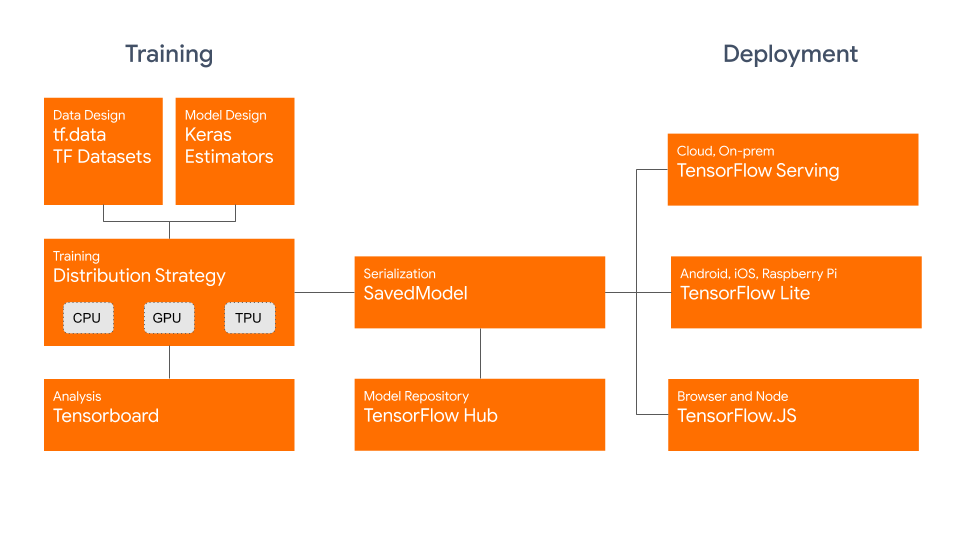

Example of the graph defined by the model, which is visualized by [TensorBoard](https://www.tensorflow.org/tensorboard/r1/summaries).

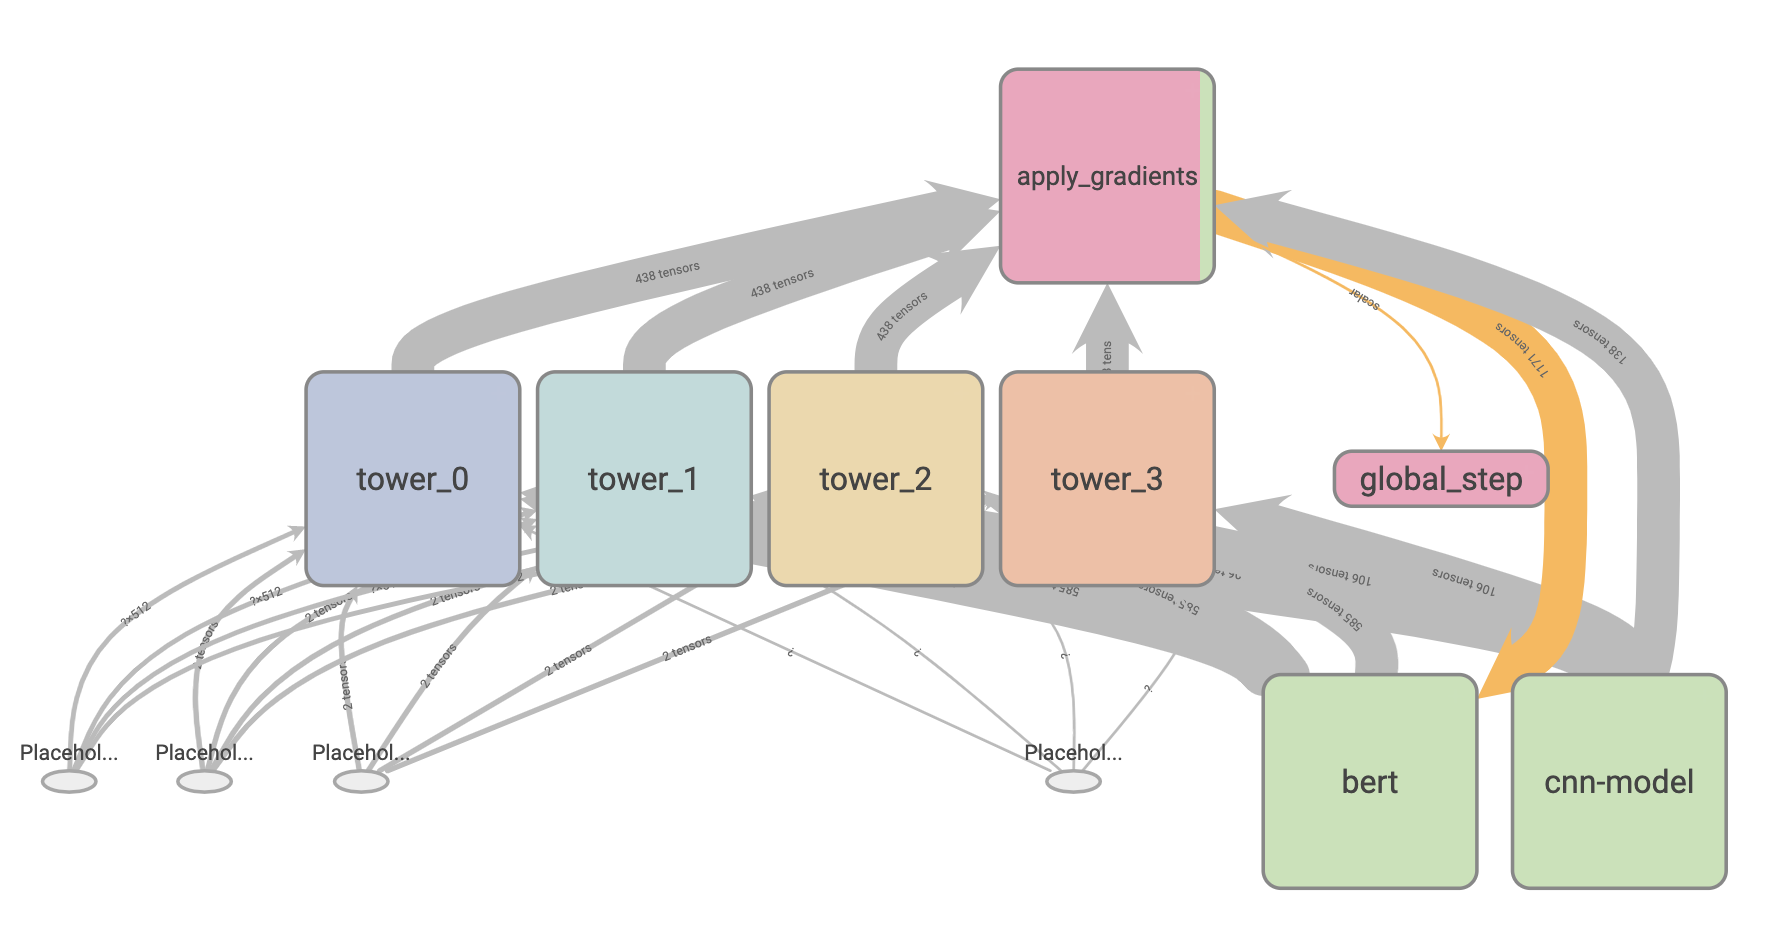

## Inside checkpoints

Before starting this tutorial, you should know what kinds of information are stored in the checkpoints. There are various parameters used by the model, including hyperparameters, weights and optimizer slot variables. TensorFlow matches variables to checkpointed values by traversing a directed graph with named edges, starting from the object being loaded. Edge names typically come from attribute names in objects.

The dependency graph looks like this:

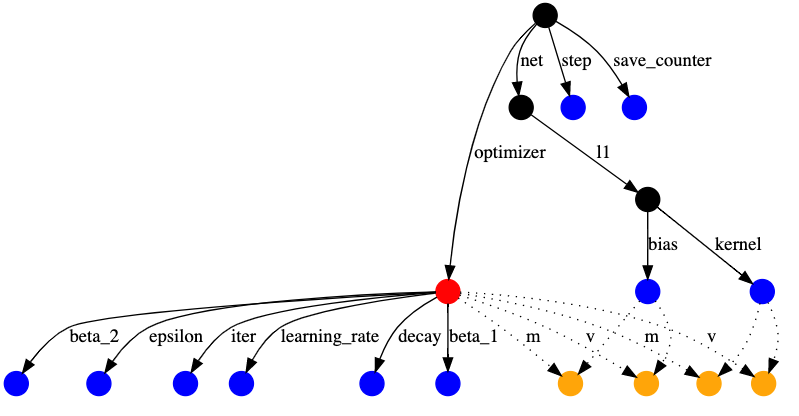

With the optimizer in red, regular variables in blue, and optimizer slot variables in orange. The other nodes, for example representing the tf.train.Checkpoint, are black.

Slot variables are part of the optimizer's state, but are created for a specific variable. For example the 'm' edges above correspond to momentum, which the Adam optimizer tracks for each variable. Slot variables are only saved in a checkpoint if the variable and the optimizer would both be saved, thus the dashed edges.

This tutorial covers APIs for writing and reading checkpoints. For more information about SavedModel API, see [Using the SavedModel format](https://www.tensorflow.org/guide/saved_model) and [Save and load models](https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training) guides.

There are several ways to save TensorFlow models, depending on the API you are using. In this section, we are going to demonstrate
- tf.keras.callbacks.ModelCheckpoint
- Model.save_weights
- tf.train.Checkpoints

For simplicity, here we use [MNIST](http://yann.lecun.com/exdb/mnist/) dataset to demonstrate how to save and load wegihts.

In [ ]:
import os

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout(x)
        return self.d2(x)

In [ ]:
tf.keras.backend.clear_session()
model = MyModel()
model.build(input_shape=(None, 28, 28))
model.summary()

## Save checkpoints during training

You can use a trained model without having to retrain it, or pick-up training where you left off - in case the training process was interrupted. The tf.keras.callbacks.ModelCheckpoint callback allows to continually save the model both during and at the end of training, and this method saves all parameters used by a model, including weights and optimizer. The callback provides several options to create unique names for checkpoints and adjust the checkpointing frequency.

## Checkpoint callback usage

In [ ]:
EPOCHS = 5

# Checkpoint path and its name
CKP_DIR_SAVE_CALLBACKS = './checkpoints_save_callbacks/ckpt-{epoch}.ckpt'
checkpoint_dir = os.path.dirname(CKP_DIR_SAVE_CALLBACKS)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CKP_DIR_SAVE_CALLBACKS, 
    verbose=1, 
    save_weights_only=True,
    period=1)

# Train the model with the new callback
model.fit(train_images, 
          train_labels,
          epochs=EPOCHS, 
          callbacks=[cp_callback],
          validation_data=(test_images,test_labels))

Now rebuild a fresh, untrained model, and evaluate it on the test set. An untrained model will perform at chance levels (~10% accuracy):

In [ ]:
# Create a new model instance
model = MyModel()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Re-evaluate the model
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Create a new, untrained model. When restoring a model from weights-only, you must have a model with the same architecture as the original model. Since it's the same model architecture, you can share weights despite that it's a different instance of the model.

After loading the weights from the checkpoint, we can re-evaluate the model. As you can see, the accuracy raises up to 85.5%, which is same as the one we have trained earlier.

In [ ]:
# Load the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

## What are these files?

The above code stores the weights to a collection of checkpoint-formatted files that contain only the trained weights in a binary format. Checkpoints contain: One or more shards that contain your model's weights. An index file that indicates which weights are stored in a which shard.

## Manually save weights

We just demonstrated how to save and load the weights into a model when using Model.fit. Manually saving them is just as simple with the Model.save_weights method, and it is quite useful during custom training. In our Deep Learning course, most of assignments and competitions are required custom training.

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
tf.keras.backend.clear_session()
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

Another thing you should notice is the difference between tf.keras.callbacks.ModelCheckpoint and Model.save_weights. The former one saves all parameters used in model, inclusing weights and optimizers, while the latter one only saves weights. No information about optimizer is saved. Therefore, if you restore the checkpoints saved by Model.save_weights method, it is not possible to pick-up training where you left off exactly. Fortunately, in most cases, information relevant to optimizer is not that important comparing to weights. In addition, since Model.save_weights only stores weights, the checkpoint files are lighter than the one created by tf.kears.callbacks.ModelCheckpoint.

In [ ]:
CKP_DIR_SAVE_WEIGHTS = './checkpoints_save_weights'

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {:0}, Loss: {:.2f}, Accuracy: {:.2f}, Test Loss: {:.2f}, Test Accuracy: {:.2f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           test_loss.result(),
                           test_accuracy.result()*100))
    
    # Use Model.save_weights during training
    # You can modify the saving frequency by simply using "if epoch == ?, then save"
    print("Saved checkpoint for step {}: {}".format(int(epoch+1), CKP_DIR_SAVE_WEIGHTS + f'/ckpt-{epoch+1}'))
    model.save_weights(os.path.join(CKP_DIR_SAVE_WEIGHTS, f'ckpt-{epoch}'))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

In [ ]:
# Create a new model instance
model = MyModel()

Here you might encounter FailedPreconditionError. Please recompile the cell containing def train_step and def test_step, and then run the following cells.

In [ ]:
for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

template = 'Test Loss: {:.2f}, Test Accuracy: {:.2f}'
print (template.format(test_loss.result(), test_accuracy.result()*100))

test_loss.reset_states()
test_accuracy.reset_states()

In [ ]:
# Restore the weights
model.load_weights('checkpoints_save_weights/ckpt-4')

for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

template = 'Test Loss: {:.2f}, Test Accuracy: {:.2f}'
print (template.format(test_loss.result(), test_accuracy.result()*100))

test_loss.reset_states()
test_accuracy.reset_states()

## Manually checkpointing

Another way to save checkpoint during custom training is to use tf.train.Checkpoint API, capturing the exact value of all parameters used by model. It is distinct from Model.save_weights, which saves only weights but the optimizer.



In [ ]:
# Create a new model instance
tf.keras.backend.clear_session()
model = MyModel()

To manually make a checkpoint you will need a tf.train.Checkpoint object. Where the objects you want to checkpoint are set as attributes on the object.

A tf.train.CheckpointManager can also be helpful for managing multiple checkpoints.

In [ ]:
CKP_DIR_SAVE_CHECKPOINTS = './checkpoints_save_checkpoints'

# Place the models and optimizers you want to store 
# as the arguments of tf.train.Checkpoint
# You can store several different models and optimizers at the same time
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, CKP_DIR_SAVE_CHECKPOINTS, max_to_keep=3)

In [ ]:
for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    template = 'Epoch {:0}, Loss: {:.2f}, Accuracy: {:.2f}, Test Loss: {:.2f}, Test Accuracy: {:.2f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           test_loss.result(),
                           test_accuracy.result()*100))
    
    # save checkpoint for each epoch
    if int(ckpt.step) % 1 == 0:
        save_path = manager.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
    
    ckpt.step.assign_add(1)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

In [ ]:
model = MyModel()

In [ ]:
for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

template = 'Test Loss: {:.2f}, Test Accuracy: {:.2f}'
print (template.format(test_loss.result(), test_accuracy.result()*100))

test_loss.reset_states()
test_accuracy.reset_states()

After the first you can pass a new model and manager, but pickup training exactly where you left off.

In [ ]:
# To load checkpoints back to our new model, you have to create another 
# "tf.train.Checkpoint" for new model and optimizer
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, CKP_DIR_SAVE_CHECKPOINTS, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

template = 'Test Loss: {:.2f}, Test Accuracy: {:.2f}'
print (template.format(test_loss.result(), test_accuracy.result()*100))

test_loss.reset_states()
test_accuracy.reset_states()

For more information about tf.train.Checkpoint and the detailed structure of saved checkpoints, please check [Training checkpoints](https://www.tensorflow.org/guide/checkpoint) guide.